# Import Modules

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
pip install transformers

     |████████████████████████████████| 2.1MB 8.4MB/s 
     |████████████████████████████████| 3.3MB 40.9MB/s 
     |████████████████████████████████| 901kB 36.3MB/s 


In [3]:
TRAIN_PATH = 'gdrive/Shareddrives/CIS530Project/train-v2.0.json'
TEST_PATH = 'gdrive/Shareddrives/CIS530Project/dev-v2.0.json'

In [4]:
from transformers import RobertaForQuestionAnswering, RobertaTokenizerFast
from transformers import AdamW

import torch
from torch.utils.data import DataLoader

import os
import requests
import json
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [5]:
with open(TRAIN_PATH, 'rb') as f:
    train_squad_dict = json.load(f)

with open(TEST_PATH, 'rb') as f:
    val_squad_dict = json.load(f)

val_squad_dict['data'][0]['paragraphs'][0]

{'context': 'The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.',
 'qas': [{'answers': [{'answer_start': 159, 'text': 'France'},
    {'answer_start': 159, 'text': 'France'},
    {'answer_start': 159, 'text': 'France'},
    {'answer_start': 159, 'text': 'France'}],
   'id': '56ddde6b9a695914005b9628',
   'is

# Training

## Read Train Data

In [ ]:
def read_squad2_train(squad_dict):
    
    # initialize lists for contexts, questions, and answers
    contexts = []
    questions = []
    answers = []
    
    # iterate through all data in squad data
    for group in squad_dict['data']:
        for passage in group['paragraphs']:
            context = passage['context']
            for qa in passage['qas']:
                question = qa['question']
                if qa['is_impossible']:
                    # For unanswerable questions, only correct answer is empty string
                    answer = {'answer_start': 0, 'answer_end': 0, 'text': ''}
                else:
                    # choose the shortest answer for convenience
                    answer = qa['answers'][0]
                    for ans in qa['answers']:
                        if len(ans['text']) < len(answer['text']):
                            answer = ans
                    answer['answer_end'] = answer['answer_start'] + len(answer['text'])
                
                # append data to lists
                contexts.append(context)
                questions.append(question)
                answers.append(answer)
    
    # return formatted data lists
    return contexts, questions, answers

train_contexts, train_questions, train_answers = read_squad2_train(train_squad_dict)

In [ ]:
train_questions[:10]

['When did Beyonce start becoming popular?',
 'What areas did Beyonce compete in when she was growing up?',
 "When did Beyonce leave Destiny's Child and become a solo singer?",
 'In what city and state did Beyonce  grow up? ',
 'In which decade did Beyonce become famous?',
 'In what R&B group was she the lead singer?',
 'What album made her a worldwide known artist?',
 "Who managed the Destiny's Child group?",
 'When did Beyoncé rise to fame?',
 "What role did Beyoncé have in Destiny's Child?"]

In [ ]:
train_answers[:10]

[{'answer_end': 286, 'answer_start': 269, 'text': 'in the late 1990s'},
 {'answer_end': 226, 'answer_start': 207, 'text': 'singing and dancing'},
 {'answer_end': 530, 'answer_start': 526, 'text': '2003'},
 {'answer_end': 180, 'answer_start': 166, 'text': 'Houston, Texas'},
 {'answer_end': 286, 'answer_start': 276, 'text': 'late 1990s'},
 {'answer_end': 335, 'answer_start': 320, 'text': "Destiny's Child"},
 {'answer_end': 524, 'answer_start': 505, 'text': 'Dangerously in Love'},
 {'answer_end': 374, 'answer_start': 360, 'text': 'Mathew Knowles'},
 {'answer_end': 286, 'answer_start': 276, 'text': 'late 1990s'},
 {'answer_end': 301, 'answer_start': 290, 'text': 'lead singer'}]

## Encode

In [ ]:
tokenizer = RobertaTokenizerFast.from_pretrained('distilroberta-base')

In [ ]:
train_encoding = tokenizer(train_contexts, train_questions, truncation=True, padding=True)

In [ ]:
train_encoding[0]

Encoding(num_tokens=512, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [ ]:
def add_token_positions(encodings, answers):
    # initialize lists to contain the token indices of answer start/end
    start_positions = []
    end_positions = []

    for i in range(len(answers)):
        # append start/end token position using char_to_token method
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end']))

        # if start position is None, the answer passage has been truncated
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length

        # end position cannot be found, char_to_token found space, so shift one token forward
        go_back = 1
        while end_positions[-1] is None:
            if answers[i]['answer_end'] == 0:
                end_positions[-1] = tokenizer.model_max_length
            else:
                end_positions[-1] = encodings.char_to_token(i, answers[i]['answer_end']-go_back)
                go_back += 1

    # update our encodings object with the new token-based start/end positions
    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

In [ ]:
# apply function to our data
add_token_positions(train_encoding, train_answers)

In [ ]:
class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

# train_dataset = SquadDataset(train_encoding)
# val_dataset = SquadDataset(val_encoding)

In [ ]:
train_dataset = SquadDataset(train_encoding)

## Train Model

In [ ]:
model = RobertaForQuestionAnswering.from_pretrained("distilroberta-base")

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForQuestionAnswering: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForQuestionAnswering were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be 

In [ ]:
# setup GPU/CPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
# move model over to detected device
model.to(device)
# activate training mode of model
model.train()
# initialize adam optimizer with weight decay (reduces chance of overfitting)
optim = AdamW(model.parameters(), lr=5e-5)

# initialize data loader for training data
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

loss_lst = []

def train(num_epochs=1):
    for epoch in range(num_epochs):
        # set model to train mode
        model.train()
        # setup loop (we use tqdm for the progress bar)
        loop = tqdm(train_loader, leave=True)
        for batch in loop:
            # initialize calculated gradients (from prev step)
            optim.zero_grad()
            # pull all the tensor batches required for training
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_positions = batch['start_positions'].to(device)
            end_positions = batch['end_positions'].to(device)
            # train model on batch and return outputs (incl. loss)
            outputs = model(input_ids, attention_mask=attention_mask,
                            start_positions=start_positions,
                            end_positions=end_positions)
            # extract loss
            loss = outputs[0]
            loss_lst.append(loss)
            # calculate loss for every parameter that needs grad update
            loss.backward()
            # update parameters
            optim.step()
            # print relevant info to progress bar
            loop.set_description(f'Epoch {epoch}')
            loop.set_postfix(loss=loss.item())

            if len(loss_lst) % 1000 == 0:
                model_path = 'gdrive/Shareddrives/CIS530Project/milestone4/zihan/model2'
                model.save_pretrained(model_path)
                tokenizer.save_pretrained(model_path)

        model_path = 'gdrive/Shareddrives/CIS530Project/milestone4/zihan/model2'
        model.save_pretrained(model_path)
        tokenizer.save_pretrained(model_path)

train()

cuda


In [ ]:
train_loss = [float(l.cpu().detach().numpy()) for l in loss_lst]

with open('gdrive/Shareddrives/CIS530Project/milestone4/zihan/model2/loss.txt', 'w') as f:
    for loss in train_loss:
        f.write("%s\n" % loss)

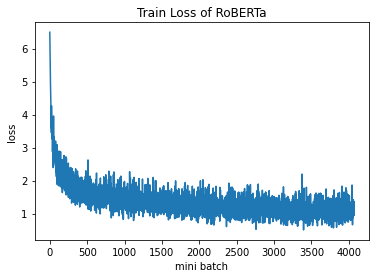

In [ ]:
plt.plot(train_loss)
plt.xlabel("mini batch")
plt.ylabel("loss")
plt.title("Train Loss of RoBERTa")
plt.show()

In [ ]:
model

RobertaForQuestionAnswering(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm):

# Validation

## Load Saved Model

In [ ]:
output_dir = './gdrive/Shareddrives/CIS530Project/milestone4/zihan/model2'

In [ ]:
model = RobertaForQuestionAnswering.from_pretrained(output_dir)
tokenizer = RobertaTokenizerFast.from_pretrained(output_dir) 

In [ ]:
model

RobertaForQuestionAnswering(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm):

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
print(device)

cuda


## Read Validation Data

In [6]:
def read_squad2_val(squad_dict):
    
    # initialize lists for contexts, questions, and answers
    contexts = []
    questions = []
    answers = []

    # iterate through all data in squad data
    for group in squad_dict['data']:
        for passage in group['paragraphs']:
            context = passage['context']
            for qa in passage['qas']:
                question = qa['question']
                answer = [a['text'] for a in qa['answers']]
                if not answer:
                    # For unanswerable questions, only correct answer is empty string
                    answer = ['']
                # append data to lists
                contexts.append(context)
                questions.append(question)
                answers.append(answer)
    
    # return formatted data lists
    return contexts, questions, answers

val_contexts, val_questions, val_answers = read_squad2_val(val_squad_dict)

## Test Model

In [ ]:
def predict(contexts, questions):
    answers = []

    for i in tqdm(range(len(questions)), desc="questions"):

        encoding = tokenizer.encode_plus(contexts[i], questions[i], truncation=True, padding=True, return_tensors="pt")
        input_ids, attention_mask = encoding["input_ids"].to(device), encoding["attention_mask"].to(device)
        
        output = model(input_ids, attention_mask=attention_mask)
        answer_start = torch.argmax(output['start_logits'])
        answer_end = torch.argmax(output['end_logits'])
        
        # Get the string versions of the input tokens.
        tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

        answer_tokens = tokens[answer_start : answer_end]
        answer = tokenizer.convert_tokens_to_string(answer_tokens)

        if answer:
            if answer[0] == ' ':
                answer = answer[1:]
        answers.append(answer)

    return answers

In [ ]:
val_preds = predict(val_contexts, val_questions)

with open('gdrive/Shareddrives/CIS530Project/milestone4/zihan/model2/val_preds.txt', 'w') as f:
    for pred in val_preds:
        f.write("%s\n" % pred)

In [ ]:
df = pd.DataFrame({"preds": val_preds, "answers": val_answers})
df.head(50)

,preds,answers
0,France,"[France, France, France, France]"
1,10th and 11th,"[10th and 11th centuries, in the 10th and 11th..."
2,"Denmark, Iceland and","[Denmark, Iceland and Norway, Denmark, Iceland..."
3,,"[Rollo, Rollo, Rollo, Rollo]"
4,10,"[10th century, the first half of the 10th cent..."
5,,[]
6,,[]
7,West Francia,[]
8,,[]
9,William the Conqueror,"[William the Conqueror, William the Conqueror,..."


## Evaluation Metrics

In [9]:
def evaluate(ans_pred, ans_true):
    """ Evaluate the average f1 score and Exact Match score for given answers.
        For each question, take the highest scores over all ground truth answers.
        Input: ans_pred: predicted answers for a set of questions (list of strings)
               ans_true: true answers (list of list of strings, empty list if
                         is_impossible==True for an unanswerable question)
        Output: EM_score (float)
                f1_score (float)
    """
    # assert(len(ans_pred) == len(ans_true), "The lengths of ans_pred and ans_true must be the same.")
    n = len(ans_pred)

    EM_sum, F1_sum = 0, 0
    for i, ans in enumerate(ans_pred):
        EM_max, f1_max = 0, 0
        if len(ans_true[i]) == 0:
            EM_max = EM(ans, "")
            f1_max = f1(ans, "")
        else:
            for one_true in ans_true[i]:
                EM_max = max(EM(ans, one_true), EM_max)
                f1_max = max(f1(ans, one_true), f1_max)
        EM_sum += EM_max
        F1_sum += f1_max

    return EM_sum/n, F1_sum/n



def f1(ans_pred, ans_true):
    """ Calculate the f1 score.
        Input: ans_pred: predicted answer for a question (string)
               ans_true: true answer (string)
        Output: f1_score (float)
    """
    pred_bag = normalize_text(ans_pred).split()
    true_bag = normalize_text(ans_true).split()
    if len(pred_bag) == 0 or len(true_bag) == 0:
        return int(pred_bag == true_bag)

    overlap = set(pred_bag) & set(true_bag)
    if len(overlap) == 0:
        return 0

    precision = len(overlap) / len(pred_bag)
    recall = len(overlap) / len(true_bag)
    f1_score = (2 * precision * recall) / (precision + recall)

    return f1_score



def EM(ans_pred, ans_true):
    """ Calculate the Exact Match score, 1 if exactly match, 0 otherwise.
        Input: ans_pred: predicted answer for a question (string)
               ans_true: true answer (string)
        Output: EM_score (integer)
    """
    return int(normalize_text(ans_pred) == normalize_text(ans_true))



def normalize_text(text):
    """ Lower text and remove punctuation, articles and extra whitespace.
        Input: text (string)
        Output: normalized_text (string)
    """
    # remove punctuations
    text = re.sub(r'[^0-9A-Za-z\u4e00-\u9fa5]', ' ', text)
    # remove articles
    text = re.sub(r'(^|\s)(a|an|the)($|\s)', ' ', text)
    # lower text
    text = text.lower()
    # remove extra white spaces
    text = " ".join(text.split())

    return text

In [ ]:
evaluate(val_preds, val_answers)

(0.550576939273983, 0.6364983343028303)

## Error Analysis

In [ ]:
possible_preds, impossible_preds = [], []
possible_answers, impossible_answers = [], []
for pred, ans in zip(val_preds, val_answers):
    if len(ans) == 1 and ans[0] == '':
        impossible_preds.append(pred)
        impossible_answers.append(ans)
    else:
        possible_preds.append(pred)
        possible_answers.append(ans)

In [ ]:
evaluate(possible_preds, possible_answers)

(0.3232118758434548, 0.4953010666628572)

In [ ]:
evaluate(impossible_preds, impossible_answers)

(0.7772918418839361, 0.7772918418839361)

# Further Training

## Train Second Epoch

In [ ]:
# initialize adam optimizer with weight decay (reduces chance of overfitting)
optim = AdamW(model.parameters(), lr=5e-5)

# initialize data loader for training data
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

loss_lst = []

def train(num_epochs=1):
    for epoch in range(num_epochs):
        # set model to train mode
        model.train()
        # setup loop (we use tqdm for the progress bar)
        loop = tqdm(train_loader, leave=True)
        for batch in loop:
            # initialize calculated gradients (from prev step)
            optim.zero_grad()
            # pull all the tensor batches required for training
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_positions = batch['start_positions'].to(device)
            end_positions = batch['end_positions'].to(device)
            # train model on batch and return outputs (incl. loss)
            outputs = model(input_ids, attention_mask=attention_mask,
                            start_positions=start_positions,
                            end_positions=end_positions)
            # extract loss
            loss = outputs[0]
            loss_lst.append(loss)
            # calculate loss for every parameter that needs grad update
            loss.backward()
            # update parameters
            optim.step()
            # print relevant info to progress bar
            loop.set_description(f'Epoch {epoch}')
            loop.set_postfix(loss=loss.item())

            if len(loss_lst) % 1000 == 0:
                model_path = 'gdrive/Shareddrives/CIS530Project/milestone4/zihan/model3'
                model.save_pretrained(model_path)
                tokenizer.save_pretrained(model_path)

                train_loss = [float(l.cpu().detach().numpy()) for l in loss_lst]
                with open('gdrive/Shareddrives/CIS530Project/milestone4/zihan/model3/loss.txt', 'w') as f:
                    for loss in train_loss:
                        f.write("%s\n" % loss)

        model_path = 'gdrive/Shareddrives/CIS530Project/milestone4/zihan/model3'
        model.save_pretrained(model_path)
        tokenizer.save_pretrained(model_path)

        train_loss = [float(l.cpu().detach().numpy()) for l in loss_lst]
        with open('gdrive/Shareddrives/CIS530Project/milestone4/zihan/model3/loss.txt', 'w') as f:
            for loss in train_loss:
                f.write("%s\n" % loss)

train()

In [ ]:
train_loss = [float(l.cpu().detach().numpy()) for l in loss_lst]

with open('gdrive/Shareddrives/CIS530Project/milestone4/zihan/model3/loss.txt', 'w') as f:
    for loss in train_loss:
        f.write("%s\n" % loss)

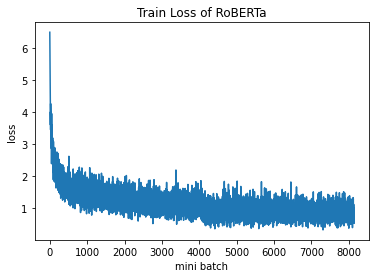

In [ ]:
loss_epoch1 = np.loadtxt('gdrive/Shareddrives/CIS530Project/milestone4/zihan/model2/loss_epoch1.txt')
loss_epoch2 = np.loadtxt('gdrive/Shareddrives/CIS530Project/milestone4/zihan/model3/loss.txt')
all_loss = np.concatenate((loss_epoch1, loss_epoch2))

plt.plot(all_loss)
plt.xlabel("mini batch")
plt.ylabel("loss")
plt.title("Train Loss of RoBERTa")
plt.show()

## Evaluation

In [ ]:
output_dir = './gdrive/Shareddrives/CIS530Project/milestone4/zihan/model3'

model = RobertaForQuestionAnswering.from_pretrained(output_dir)
tokenizer = RobertaTokenizerFast.from_pretrained(output_dir)

model

RobertaForQuestionAnswering(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm):

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
print(device)

cuda


In [ ]:
def predict(contexts, questions):
    answers = []

    for i in tqdm(range(len(questions)), desc="questions"):

        encoding = tokenizer.encode_plus(contexts[i], questions[i], truncation=True, padding=True, return_tensors="pt")
        input_ids, attention_mask = encoding["input_ids"].to(device), encoding["attention_mask"].to(device)
        
        output = model(input_ids, attention_mask=attention_mask)
        answer_start = torch.argmax(output['start_logits'])
        answer_end = torch.argmax(output['end_logits'])
        
        # Get the string versions of the input tokens.
        tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

        answer_tokens = tokens[answer_start : answer_end]
        answer = tokenizer.convert_tokens_to_string(answer_tokens)

        if answer:
            if answer[0] == ' ':
                answer = answer[1:]
        answers.append(answer)

    return answers

In [ ]:
val_preds = predict(val_contexts, val_questions)

with open('gdrive/Shareddrives/CIS530Project/milestone4/zihan/model3/val_preds.txt', 'w') as f:
    for pred in val_preds:
        f.write("%s\n" % pred)

In [ ]:
evaluate(val_preds, val_answers)

(0.5449338836014487, 0.6371767067731869)

In [ ]:
possible_preds, impossible_preds = [], []
possible_answers, impossible_answers = [], []
for pred, ans in zip(val_preds, val_answers):
    if len(ans) == 1 and ans[0] == '':
        impossible_preds.append(pred)
        impossible_answers.append(ans)
    else:
        possible_preds.append(pred)
        possible_answers.append(ans)

In [ ]:
evaluate(possible_preds, possible_answers)

(0.3368758434547908, 0.5216260188120703)

In [ ]:
evaluate(impossible_preds, impossible_answers)

(0.7523969722455845, 0.7523969722455845)

## Train Accuracy

In [ ]:
tr_contexts, tr_questions, tr_answers = read_squad2_val(train_squad_dict)

tr_preds = predict(tr_contexts, tr_questions)

with open('gdrive/Shareddrives/CIS530Project/milestone4/zihan/model3/tr_preds.txt', 'w') as f:
    for pred in tr_preds:
        f.write("%s\n" % pred)

In [ ]:
evaluate(tr_preds, tr_answers)

(0.5466202165455536, 0.6991579886283313)

# Pretrained Model

In [7]:
tokenizer = RobertaTokenizerFast.from_pretrained('distilroberta-base')
model = RobertaForQuestionAnswering.from_pretrained("distilroberta-base")

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForQuestionAnswering: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForQuestionAnswering were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be 

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
print(device)

cuda


In [8]:
def predict(contexts, questions):
    answers = []

    for i in tqdm(range(len(questions)), desc="questions"):

        encoding = tokenizer.encode_plus(contexts[i], questions[i], truncation=True, padding=True, return_tensors="pt")
        input_ids, attention_mask = encoding["input_ids"].to(device), encoding["attention_mask"].to(device)
        
        output = model(input_ids, attention_mask=attention_mask)
        answer_start = torch.argmax(output['start_logits'])
        answer_end = torch.argmax(output['end_logits'])
        
        # Get the string versions of the input tokens.
        tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

        answer_tokens = tokens[answer_start : answer_end]
        answer = tokenizer.convert_tokens_to_string(answer_tokens)

        if answer:
            if answer[0] == ' ':
                answer = answer[1:]
        answers.append(answer)

    return answers

In [12]:
val_preds = predict(val_contexts, val_questions)
evaluate(val_preds, val_answers)

(0.15994272719615935, 0.1860814778613745)

In [13]:
possible_preds, impossible_preds = [], []
possible_answers, impossible_answers = [], []
for pred, ans in zip(val_preds, val_answers):
    if len(ans) == 1 and ans[0] == '':
        impossible_preds.append(pred)
        impossible_answers.append(ans)
    else:
        possible_preds.append(pred)
        possible_answers.append(ans)

In [14]:
evaluate(possible_preds, possible_answers)

(0.0005060728744939271, 0.05285853351013949)

In [15]:
evaluate(impossible_preds, impossible_answers)

(0.3189234650967199, 0.3189234650967199)